# stochastic gradient descent

## 前面的程式都和上個範例--"數字手寫辨識"一樣

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

In [2]:
# Define activation(sigmoid)_layer functions
class sigmoid_layer():
    def __init__(self):
        self.out = None #這裡的out就是影片與上面方程式中的a
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out  #記錄在class中作計算backward備用
        
        return out
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out # dL/da * da/dz = dL/da * y * (1-y)
        
        return dx
# Define affine_layer functions    
class affine_layer():
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None
        self.dW =None
        self.db = None
        
    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        
        self.x = x #記錄在class中作計算backward備用
        out = np.dot(self.x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        dx = dx.reshape(*self.original_x_shape)
        
        return dx
    
def softmax(x):
    if x.ndim == 2:
        x = x.T # Transpose it
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    return np.exp(x) / np.sum(np.exp(x))

# define cross_entropy
def cross_entropy(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class softmax_with_crossentropy():
    def __init__(self):
        self.loss = None
        self.y = None # softmax output
        self.t = None # target (ground-truth)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)#將predict後的結果餵入最後的softmax作為最後的預測(y_pred)
        self.loss = cross_entropy(self.y, self.t)
        
        return self.loss
    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size #以predict 與 truth的差值除以batch size, 
                                            #作為bp的起點(事實上就是Loss func對最後一步z的偏微分)
        
        return dx

In [3]:
from collections import OrderedDict # this is a built-in function -- dictionary with order

#ordereddic和一般dict差別的參考範例：https://blog.csdn.net/liangguohuan/article/details/7088304

class Two_layerNet_bp:
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size, 
                 weight_init_std = 0.01):
        #------------------------------定義好要用的陣列---------------------------------
        self.params = {}#用dict存放所有陣列
        self.params['w1'] = weight_init_std * np.random.randn(input_size, hidden_size) #以亂數作為w的起始值
        self.params['b1'] = np.zeros(hidden_size) #以0作為b的起始值
        self.params['w2'] = weight_init_std * np.random.randn(hidden_size, output_size) #以亂數作為w的起始值
        self.params['b2'] = np.zeros(output_size) #以0作為b的起始值
        
        #------------------------------build network---------------------------------
        self.layers = OrderedDict()#用ordereddic存放所有layers
        self.layers['affine_1'] = affine_layer(self.params['w1'], self.params['b1'])
        self.layers['sigmoid_1'] = sigmoid_layer()
        self.layers['affine_2'] = affine_layer(self.params['w2'], self.params['b2'])
        # output layer
        self.lastlayer = softmax_with_crossentropy()
    #---------------------predict----------------------    
    def predict(self, x):
        # forward
        for layer in self.layers.values(): #從第一層開始,將最初的x餵進layer,並將輸出當作下一層layer的input持續做到倒數第二層(不包含最後的softmax層)，得到output
            x = layer.forward(x) 
        
        return x
#--------------------------lost function(with cross entropy)---------------              
    def loss(self, x, y_true):
        y_pred = self.predict(x) #調用上面的predict function
        return self.lastlayer.forward(y_pred, y_true)#仔細看到上個cell最後一個class "softmax_with_crossentropy()"的"forward"，
                                                    #除了計算softmax、cross_entropy也將計算結果、y_pred、y_true記錄在softmax_with_crossentropy()內,
                                                    #在調用backward時就不用再餵入y_pred,y_true
#----------------------------------accuracy--------------------------------       
    def compute_acc(self, x, y_true):
        y_pred = self.predict(x)
        # take argmax
        y_pred = y_pred.argmax(axis = 1) 
        y_true = y_true.argmax(axis = 1)
        
        acc = np.sum(y_pred == y_true) / len(y_true)
        return acc
#-----------------------------optimizer(gradient)---------------------------
    def gradient(self, x, t):
        # forward path
        self.loss(x, t) #這步回頭看function就會了解，除了做了loss，也做loss前的predict，另外predict同時各層affine layer 的input "x"、
                        #optimizer(cross)的input "t" and "y"、activation function layer的output "out"與也會記錄在分別的class中,
                        #而各層affine layer的x就是'partial(z)/partial(w)'，所以不用覺得似乎少了許多步驟
        
        # backward
        dout = 1
        dout = self.lastlayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse() #將layers反過來準備開始backward
        for layer in layers:#backward 開始!!!!
            dout = layer.backward(dout)#分別計算dw、db並各自記錄在自己的layer中
        
        # gradient init and setting
        grads = {}
        grads['w1'] = self.layers['affine_1'].dW
        grads['b1'] = self.layers['affine_1'].db
        grads['w2'] = self.layers['affine_2'].dW
        grads['b2'] = self.layers['affine_2'].db
        
        return grads

## 在這邊與上個範例開始有點不同，我們將導入batch size的觀念!
## 現在我們先嘗試一般的gradient descent(batch size=training size)(看完所有資料一遍才更新一次參數)

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time

'''-----------------------------------資料前處理---------------------------------------------'''
digits = load_digits()
x_, y_ = digits.data, digits.target


#---------將資料做One-Hot Encoding---------
y_one_hot = np.zeros((len(y_), 10))
y_one_hot[np.arange(len(y_)), y_] = 1 
#---------one way of normalization--------
x_ = x_ / x_.max() # normailze it to 0 - 1 標準化

#----------------------------資料training set, testing set 分割---------------------------------------
x_train, x_test, y_train, y_test = train_test_split(x_, y_one_hot, test_size = 0.1, stratify = y_)
'''--------------------------------建立List準備存過程中的ass與loss變化----------------------------'''
# define training settings ------------
train_loss_list = []
train_acc_list = []
test_acc_list = []
datatimes_acc_list=[]
datatimes_loss_list=[]
'''-----------------------------------參數設定與創建新模型--------------------------------------------'''
epochs = 5
train_size = x_train.shape[0] # numbers of training samples
bz = train_size # batch size
lr = 0.1 # learning rate

network = Two_layerNet_bp(input_size=64, hidden_size=25, output_size=10)
'''-----------------------------------start_training---------------------------------------------'''
starttime=time.time()
k=0
for i in tqdm(range(epochs)):
    x_train, y_train = shuffle(x_train, y_train)
    total_batch = int(train_size / bz)
    for j in np.arange(total_batch):
        #-------------------------------取一個batch 的資料-------------------------------------
        batch_idx_start = j * bz
        batch_idx_stop = (j+1) * bz

        x_batch = x_train[batch_idx_start : batch_idx_stop] 
        y_batch = y_train[batch_idx_start : batch_idx_stop]
        #------------------------------------------------------------------------------------
    
    
        grad = network.gradient(x_batch, y_batch) # already contain a feed-forward processing in this step
        k=k+bz
        
        for key in ("w1", "b1", "w2", "b2"):
            network.params[key] -= lr * grad[key]

        this_loss = network.loss(x_batch, y_batch)
        train_loss_list.append(this_loss)
        datatimes_loss_list.append(k)
       #每執行5 batch紀錄一次 
        if j % 5 == 0:
            # compute accuracy for every 50 updates
            train_acc = network.compute_acc(x_train, y_train)
            test_acc = network.compute_acc(x_test, y_test)

            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            datatimes_acc_list.append(k)
timerange=time.time()-starttime        
print('總共費時：',timerange)  
   

100%|██████████| 5/5 [00:00<00:00, 133.49it/s]

總共費時： 0.04054856300354004


## 現在我們再來嘗試stochastic gradient descent(batch size=1)(看完一筆資料就更新一次參數)

In [5]:

'''--------------------------------建立List準備用來存過程中的acc與loss變化-------------------------'''
# define training settings ------------
train_loss_list2 = []
train_acc_list2 = []
test_acc_list2 = []
datatimes_acc_list2=[]
datatimes_loss_list2=[]
'''-----------------------------------參數設定與創建新模型--------------------------------------------'''
epochs = 5
train_size = x_train.shape[0] # numbers of training samples
bz = 1 # batch size
lr = 0.1 # learning rate

network = Two_layerNet_bp(input_size=64, hidden_size=25, output_size=10)
'''-----------------------------------start_training---------------------------------------------'''
starttime=time.time()
k=0
for i in tqdm(range(epochs)):
    x_train, y_train = shuffle(x_train, y_train)
    total_batch = int(train_size / bz)
    for j in np.arange(total_batch):
        #-------------------------------取一個batch 的資料-------------------------------------
        batch_idx_start = j * bz
        batch_idx_stop = (j+1) * bz

        x_batch = x_train[batch_idx_start : batch_idx_stop] 
        y_batch = y_train[batch_idx_start : batch_idx_stop]
        #------------------------------------------------------------------------------------
    
    
        grad = network.gradient(x_batch, y_batch) # already contain a feed-forward processing in this step
        k=k+bz#記錄現在總共已經看過幾筆資料了
        for key in ("w1", "b1", "w2", "b2"):
            network.params[key] -= lr * grad[key]

        this_loss = network.loss(x_batch, y_batch)
        train_loss_list2.append(this_loss)
        datatimes_loss_list2.append(k)
       #每執行5 batch紀錄一次acc
        if j % 5 == 0:
            
            train_acc = network.compute_acc(x_train, y_train)
            test_acc = network.compute_acc(x_test, y_test)

            train_acc_list2.append(train_acc)
            test_acc_list2.append(test_acc)
            datatimes_acc_list2.append(k)
timerange=time.time()-starttime        
print('總共費時：',timerange)  

100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

總共費時： 4.073269844055176


## 畫圖比較

loss趨勢圖，x座標是看過單筆資料的次數，y軸是loss值


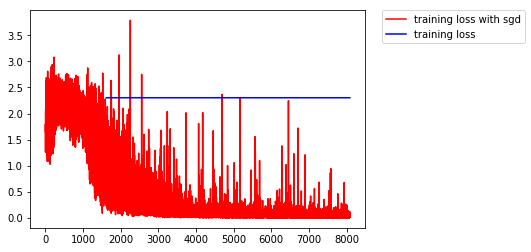

acc趨勢圖，x座標是看過單筆資料的次數，y軸是正確率


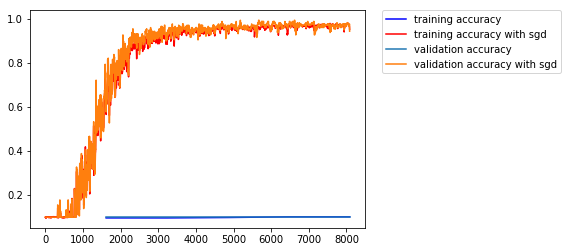

In [6]:
  '''-----------------------------------圖形化---------------------------------------------'''  
#------------------------------------------------------plot------------------------------------------------------
#print("Train accuarcy, Test accuracy | " + str(train_acc) + ", " + str(test_acc))
    
#lose圖
print('loss趨勢圖，x座標是看過單筆資料的次數，y軸是loss值')
plt.plot(datatimes_loss_list2, train_loss_list2,'r-', label = 'training loss with sgd')
plt.plot(datatimes_loss_list, train_loss_list,'b-',label = 'training loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
print('acc趨勢圖，x座標是看過單筆資料的次數，y軸是正確率')
plt.plot(datatimes_acc_list, train_acc_list,'b-',  label = 'training accuracy')
plt.plot(datatimes_acc_list2, train_acc_list2,'r-',  label = 'training accuracy with sgd')
plt.plot(datatimes_acc_list, test_acc_list, label = 'validation accuracy')
plt.plot(datatimes_acc_list2, test_acc_list2 , label = 'validation accuracy with sgd')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Exercise
分別試著完成以下動作

1. 試著加大epoch，觀察loss和acc的變化
2. 試著改變batch size並比較執行結果與執行時間
3. 試著透過切換立足點，目前範例是限制在看相同次數的情況下我們得到的結果，可以嘗試改變成限制在相同運行時間下，比較最後得到的acc和loss